In [1]:
import numpy as np
import matplotlib.pyplot as plt
import magpylib as magpy
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

In [2]:
"Define Spacecraft Moment"
moment = (0.1404,0,0)

# sensor
sensor = magpy.Sensor(pixel=[(0, 0, 0), (0.3326, 0, 0), (0.6634, 0, 0), (1.0695, 0,  0)])
sensor.position = (0.7053, 0, None) # m

sensor_z_values = np.arange(-.24, .25, 0.12)
rotation_steps = np.arange(0, 360, 20)  # 0 to 355 degrees
data_records_rhino = []

for height in sensor_z_values:
    sensor.position[2] = height
    pixel_positions = sensor.pixel + sensor.position
    for angle in rotation_steps:
        spacecraft_dipole = magpy.misc.Dipole(position=(0,0,0),  moment=moment) # Am**2

        "Rotate Dipole to simulate moving magneomteters"
        spacecraft_dipole.rotate_from_angax(angle, "z", start=0)

        "Find new sensor positions in dipole frame"
        rotation = R.from_euler('z', -angle, degrees=True)
        rotated_positions = np.round(rotation.apply(pixel_positions),3)
        reading = sensor.getB(spacecraft_dipole)
        reading = rotation.apply(reading)

        "Save data"
        for i in range(4):
            # Append the record
            data_records_rhino.append({
                "height": height,
                "angle": angle,
                "sensor": i,
                'x': rotated_positions[i][0],
                'y': rotated_positions[i][1],
                'z': rotated_positions[i][2],
                'Bx': reading[i][0],
                'By': reading[i][1],
                'Bz': reading[i][2],
            })

df = pd.DataFrame(data_records_rhino)

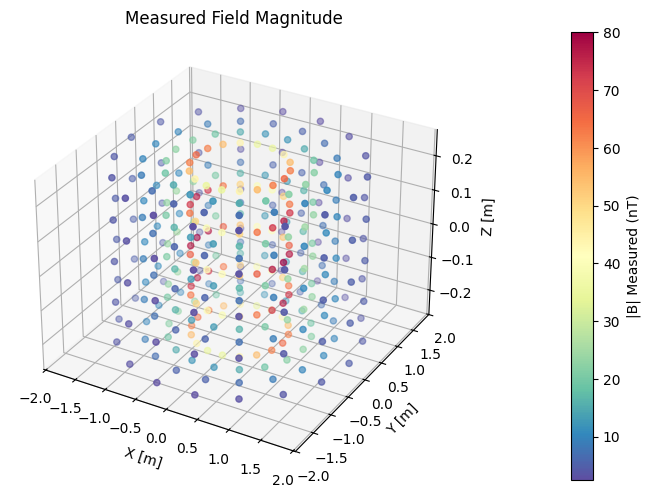

In [3]:
B_meas_mag = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)*1e9
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
sc1 = ax1.scatter(df["x"], df["y"], df["z"], c=B_meas_mag, cmap="Spectral_r", s=20)
cbar1 = plt.colorbar(sc1, ax=ax1, fraction=0.03, pad=0.1)
cbar1.set_label("|B| Measured (nT)", rotation=90)
ax1.set_title("Measured Field Magnitude")
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_zlabel("Z [m]")

plt.tight_layout()
plt.show()

In [ ]:
from magprime.characterization import find_sh

"Prepare data"
x,y,z = df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy()
r = np.sqrt(x**2 + y**2 + z**2)

Bx,By,Bz = df['Bx'].to_numpy(), df['By'].to_numpy(), df['Bz'].to_numpy()

coeffs, B_pred = find_sh(x,y,z, Bx, By, Bz, l_max=1, a = np.min(r), predict=True)

0.7048467918633099


c:\ProgramData\Anaconda3\envs\latest\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [5]:
coeffs

{(1, 0): {'g': np.float64(-4.9589957666995465e-25), 'h': 0.0},
 (1, 1): {'g': np.float64(4.0110075735287564e-08),
  'h': np.float64(1.7956777793618318e-21)}}